In [1]:
!pip install google-play-scraper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [3]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

###Libraries

In [36]:
from google_play_scraper import Sort, reviews
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm import tqdm
import openai
import time


###Data Processing

In [5]:
def get_reviews(app_package, n_reviews=20000):
    all_reviews = []
    count = 0

    while count < n_reviews:
        result, _ = reviews(
            app_package,
            lang='en',
            country='us',
            sort=Sort.NEWEST,
            count=200,
            filter_score_with=None
        )
        all_reviews.extend(result)
        count = len(all_reviews)

    df = pd.DataFrame(all_reviews)
    return df.head(n_reviews)

In [6]:
os.makedirs("data/raw", exist_ok=True)

In [7]:
duolingo_reviews = get_reviews("com.duolingo", n_reviews=20000)
duolingo_reviews.to_csv("data/raw/duolingo_reviews.csv", index=False)


In [8]:
duolingo_reviews.to_csv("data/raw/duolingo_reviews.csv", index=False)


In [9]:
df = pd.read_csv("data/raw/duolingo_reviews.csv")
df = df[["score", "content", "at"]].dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   score    20000 non-null  int64 
 1   content  20000 non-null  object
 2   at       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [10]:
df["at"] = pd.to_datetime(df["at"])


In [11]:
df

,score,content,at
0,5,"I need this but cause I'm American Indian, Mex...",2025-07-08 09:28:27
1,5,good 👍,2025-07-08 09:28:12
2,3,Super Duolingo saya tidak bisa latihan mendeng...,2025-07-08 09:26:27
3,5,it's a nice app,2025-07-08 09:25:27
4,1,uses ai🥀,2025-07-08 09:24:13
...,...,...,...
19995,5,GREAT for LEARNING!!!,2025-07-08 06:09:09
19996,4,Honestly I think it is the easiest way for any...,2025-07-08 06:08:28
19997,5,I like this app. My friend told me to use this...,2025-07-08 06:08:16
19998,5,والله حقيقي ممتع وبعلمك بصورة ذكية بيخليك تراج...,2025-07-08 06:07:48


In [12]:
df["at"].dtypes


dtype('<M8[ns]')

In [13]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned"] = df["content"].apply(clean_text)

In [14]:
df[["content", "cleaned"]]

,content,cleaned
0,"I need this but cause I'm American Indian, Mex...",i need this but cause im american indian mexic...
1,good 👍,good
2,Super Duolingo saya tidak bisa latihan mendeng...,super duolingo saya tidak bisa latihan mendeng...
3,it's a nice app,its a nice app
4,uses ai🥀,uses ai
...,...,...
19995,GREAT for LEARNING!!!,great for learning
19996,Honestly I think it is the easiest way for any...,honestly i think it is the easiest way for any...
19997,I like this app. My friend told me to use this...,i like this app my friend told me to use this ...
19998,والله حقيقي ممتع وبعلمك بصورة ذكية بيخليك تراج...,


#### Adding Sentiment score based and text based

In [15]:
def label_sentiment(score):
    if score >= 4:
        return "positive"
    elif score == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment_score_based"] = df["score"].apply(label_sentiment)


In [16]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_text_based"] = df["cleaned"].apply(vader_sentiment)

In [17]:
df

,score,content,at,cleaned,sentiment_score_based,sentiment_text_based
0,5,"I need this but cause I'm American Indian, Mex...",2025-07-08 09:28:27,i need this but cause im american indian mexic...,positive,neutral
1,5,good 👍,2025-07-08 09:28:12,good,positive,positive
2,3,Super Duolingo saya tidak bisa latihan mendeng...,2025-07-08 09:26:27,super duolingo saya tidak bisa latihan mendeng...,neutral,positive
3,5,it's a nice app,2025-07-08 09:25:27,its a nice app,positive,positive
4,1,uses ai🥀,2025-07-08 09:24:13,uses ai,negative,neutral
...,...,...,...,...,...,...
19995,5,GREAT for LEARNING!!!,2025-07-08 06:09:09,great for learning,positive,positive
19996,4,Honestly I think it is the easiest way for any...,2025-07-08 06:08:28,honestly i think it is the easiest way for any...,positive,positive
19997,5,I like this app. My friend told me to use this...,2025-07-08 06:08:16,i like this app my friend told me to use this ...,positive,positive
19998,5,والله حقيقي ممتع وبعلمك بصورة ذكية بيخليك تراج...,2025-07-08 06:07:48,,positive,neutral


In [18]:
df["sentiment_score_based"].value_counts(normalize=True)


,proportion
sentiment_score_based,
positive,0.85
negative,0.09
neutral,0.06


In [19]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def transformer_sentiment(text):
    encoded_input = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits.numpy()[0])
    labels = ["negative", "neutral", "positive"]
    return labels[scores.argmax()]


trying with sample first

In [21]:
df_sample = df.sample(1000, random_state=42).copy()  # for testing speed
df_sample["sentiment_cardiff"] = df_sample["cleaned"].apply(transformer_sentiment)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [22]:
df_sample[["score", "cleaned", "sentiment_score_based", "sentiment_text_based", "sentiment_cardiff"]].sample(5)


,score,cleaned,sentiment_score_based,sentiment_text_based,sentiment_cardiff
3352,4,easy to operate,positive,positive,positive
8862,5,this is honestly my favorite language app i ha...,positive,positive,positive
438,5,i enjoy learning french and the duo animations...,positive,positive,positive
19715,4,everything about duo is best,positive,positive,positive
7920,3,duolingo is a good learning app and easy to us...,neutral,positive,negative


In [23]:
(df_sample["sentiment_text_based"] == df_sample["sentiment_cardiff"]).mean()


np.float64(0.814)

Now let's do that on whole data, and keep analyzing!

In [24]:
tqdm.pandas()

df["sentiment_cardiff"] = df["cleaned"].progress_apply(transformer_sentiment)


100%|██████████| 20000/20000 [42:58<00:00,  7.76it/s]


In [25]:
agreement = (df["sentiment_text_based"] == df["sentiment_cardiff"]).mean()
print(f"Agreement rate: {agreement:.2%}")

Agreement rate: 82.50%


In [26]:
mismatches = df[df["sentiment_text_based"] != df["sentiment_cardiff"]]
mismatches[["score", "cleaned", "sentiment_text_based", "sentiment_cardiff"]].sample(5)


,score,cleaned,sentiment_text_based,sentiment_cardiff
12900,1,i cant sign in my account im stock on the load...,neutral,negative
1316,2,this rating is especially for the danish cours...,positive,negative
14709,3,it is a wonderful app what i find tricky is as...,positive,negative
9870,3,,neutral,positive
16177,4,this app is amazing but nowadays it is not wor...,positive,negative


In [27]:
interesting = mismatches.sample(10)
for _, row in interesting.iterrows():
    print(f"⭐️ {row['score']} | Text: {row['cleaned']}\n→ Score-based: {row['sentiment_text_based']} | AI-based: {row['sentiment_cardiff']}\n")


⭐️ 1 | Text: ai slop
→ Score-based: neutral | AI-based: negative

⭐️ 5 | Text: i can leern every language now tanks to duolingo
→ Score-based: neutral | AI-based: positive

⭐️ 5 | Text: its very exellent
→ Score-based: neutral | AI-based: positive

⭐️ 5 | Text: 
→ Score-based: neutral | AI-based: positive

⭐️ 1 | Text: i cant sign in my account im stock on the loading screen
→ Score-based: neutral | AI-based: negative

⭐️ 5 | Text: its very exellent
→ Score-based: neutral | AI-based: positive

⭐️ 4 | Text: just stop those adds after every lesson otherwise its best platform to learn any of the language
→ Score-based: positive | AI-based: neutral

⭐️ 5 | Text: 
→ Score-based: neutral | AI-based: positive

⭐️ 4 | Text: just stop those adds after every lesson otherwise its best platform to learn any of the language
→ Score-based: positive | AI-based: neutral

⭐️ 3 | Text: super duolingo saya tidak bisa latihan mendengar di bagian training
→ Score-based: positive | AI-based: neutral



Let's explore the mismatch ones

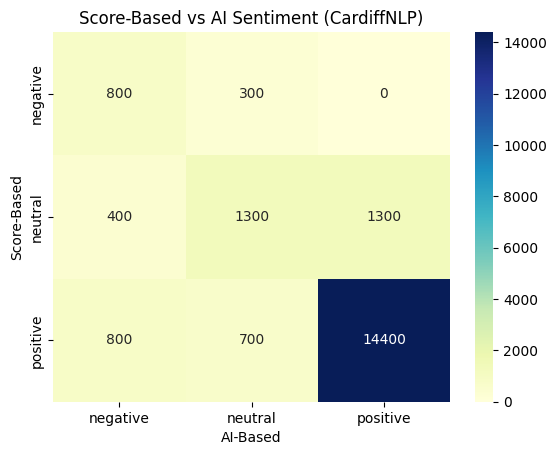

In [28]:
conf_mat = pd.crosstab(df["sentiment_text_based"], df["sentiment_cardiff"])
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Score-Based vs AI Sentiment (CardiffNLP)")
plt.ylabel("Score-Based")
plt.xlabel("AI-Based")
plt.show()


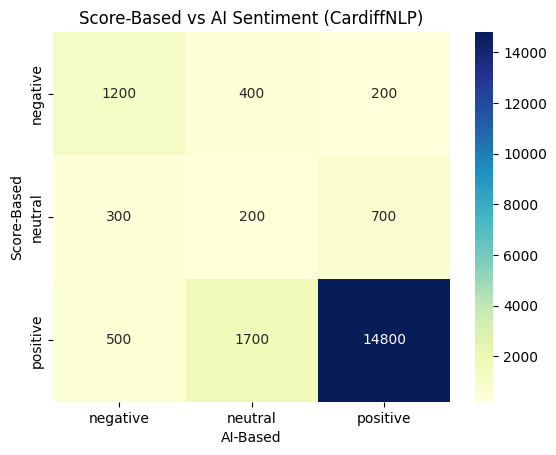

In [29]:
conf_mat = pd.crosstab(df["sentiment_score_based"], df["sentiment_cardiff"])
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Score-Based vs AI Sentiment (CardiffNLP)")
plt.ylabel("Score-Based")
plt.xlabel("AI-Based")
plt.show()

In [30]:
pd.crosstab(df["sentiment_text_based"], df["sentiment_cardiff"], normalize='index')

sentiment_cardiff,negative,neutral,positive
sentiment_text_based,,,
negative,0.727273,0.272727,0.000000
neutral,0.133333,0.433333,0.433333
positive,0.050314,0.044025,0.905660


High aggrement on positive class, makes sense.
However, on neutral class they did not get along very well.

In [31]:
pd.crosstab(df["sentiment_score_based"], df["sentiment_cardiff"], normalize='index')

sentiment_cardiff,negative,neutral,positive
sentiment_score_based,,,
negative,0.666667,0.222222,0.111111
neutral,0.250000,0.166667,0.583333
positive,0.029412,0.100000,0.870588


In [32]:
pd.crosstab(df["sentiment_text_based"], df["sentiment_score_based"], normalize='index')

sentiment_score_based,negative,neutral,positive
sentiment_text_based,,,
negative,0.818182,0.000000,0.181818
neutral,0.133333,0.066667,0.800000
positive,0.031447,0.062893,0.905660


So far, the results actually make a lot of sense.

Both positive and negative reviews are understood pretty well, no matter whether you're using star ratings or AI models. But when it comes to the neutral reviews things are different.
That is expected.

Most people don’t leave a 3-star review and say, "it is average". That’s why score-based sentiment struggles with neutrality — it’s not always clear what a 3-star rating really means.

What I’m actually curious about now is how CardiffNLP compares to VADER in these tricky situations. Can a transformer model actually spot subtle frustration or passive-aggressive tone — the kind that a rule-based system might miss?

That’s what exploring next?

My hypothesis is:
**CardiffNLP should be better at detecting passive-aggressive or subtly negative reviews — especially when VADER misses them.**

Let's see

In [33]:
vader_vs_cardiff = df[df["sentiment_text_based"] != df["sentiment_cardiff"]]
print(f"Total mismatches: {len(vader_vs_cardiff)}")

Total mismatches: 3500


In [34]:
#Random samples from the disagreements
for _, row in vader_vs_cardiff.sample(25, random_state=42).iterrows():
    print(f"⭐️ {row['score']} | Text: {row['cleaned']}\n→ VADER: {row['sentiment_text_based']} | Cardiff: {row['sentiment_cardiff']}\n")


⭐️ 3 | Text: this program does work but it assumes you have no experience with the language of your choice and also doesnt necessarily teach you the dialect of the language youre learning that will be most helpful ie im taking the spanish course and its teaching proper spanish useful in spain but not in puerto rico according to my fiance who was born in puerto rico
→ VADER: positive | Cardiff: negative

⭐️ 3 | Text: 
→ VADER: neutral | Cardiff: positive

⭐️ 5 | Text: super app he
→ VADER: positive | Cardiff: neutral

⭐️ 1 | Text: is app me muje aisa lag raha hai ki thode change ho sakta hai jese ki muje yaha se english sikhani hai par es app me apko suru se suru kare vale stage me direct hindi word diya hota hai uska muje english word select karna hai jab apko vo language ati hi nhi hai to aap ans kese doge
→ VADER: negative | Cardiff: neutral

⭐️ 5 | Text: number
→ VADER: positive | Cardiff: neutral

⭐️ 5 | Text: 
→ VADER: neutral | Cardiff: positive

⭐️ 5 | Text: you can learn so muc

### Let's see the label reasoning

In [35]:
!pip install openai

In [37]:
# Your OpenAI API key
openai.api_key = ""

In [38]:
# Lists to collect results
gpt_sentiments = []
gpt_reasons = []

def ask_gpt_sentiment(review_text, star_score):
    prompt = f"""
You're analyzing app reviews. Each review includes a user-written comment and a star score (1 to 5).

Your task is to:
1. Determine the overall sentiment of the review text: positive, neutral, or negative.
2. Explain your reasoning in 1-2 sentences.

Review Text: "{review_text}"
Star Score: {star_score}

Sentiment:
"""

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3,
            max_tokens=200
        )
        reply = response["choices"][0]["message"]["content"]
        return reply
    except Exception as e:
        return f"error\n{str(e)}"

# Run over all mismatches (or sample)
for _, row in vader_vs_cardiff.iterrows():
    reply = ask_gpt_sentiment(row["cleaned"], row["score"])
    lines = reply.strip().split("\n")
    sentiment = lines[0].strip().lower()
    reason = " ".join(lines[1:]).strip()
    gpt_sentiments.append(sentiment)
    gpt_reasons.append(reason)
    time.sleep(1.2)  # avoid rate limit

# Add results to DataFrame
vader_vs_cardiff["sentiment_gpt"] = gpt_sentiments
vader_vs_cardiff["reason_gpt"] = gpt_reasons

KeyboardInterrupt: 

In [39]:
vader_vs_cardiff = vader_vs_cardiff.iloc[:len(gpt_sentiments)].copy()
vader_vs_cardiff["sentiment_gpt"] = gpt_sentiments
vader_vs_cardiff["reason_gpt"] = gpt_reasons

In [40]:
vader_vs_cardiff


,score,content,at,cleaned,sentiment_score_based,sentiment_text_based,sentiment_cardiff,sentiment_gpt,reason_gpt
2,3,Super Duolingo saya tidak bisa latihan mendeng...,2025-07-08 09:26:27,super duolingo saya tidak bisa latihan mendeng...,neutral,positive,neutral,error,"You tried to access openai.ChatCompletion, but..."
22,5,I can leern every language now tanks to Duolingo.,2025-07-08 09:06:50,i can leern every language now tanks to duolingo,positive,neutral,positive,error,"You tried to access openai.ChatCompletion, but..."
33,1,ai slop,2025-07-08 08:57:27,ai slop,negative,neutral,negative,error,"You tried to access openai.ChatCompletion, but..."
48,2,Usually I'm struggling with the french course ...,2025-07-08 08:46:22,usually im struggling with the french course i...,negative,negative,neutral,error,"You tried to access openai.ChatCompletion, but..."
52,5,it's so like bacicly when you get something wr...,2025-07-08 08:41:50,its so like bacicly when you get something wro...,positive,positive,neutral,error,"You tried to access openai.ChatCompletion, but..."
...,...,...,...,...,...,...,...,...,...
9980,5,number 1,2025-07-08 06:22:11,number,positive,positive,neutral,error,"You tried to access openai.ChatCompletion, but..."
9982,5,gooooooooood,2025-07-08 06:16:28,gooooooooood,positive,neutral,positive,error,"You tried to access openai.ChatCompletion, but..."
9991,5,супер,2025-07-08 06:11:52,,positive,neutral,positive,error,"You tried to access openai.ChatCompletion, but..."
9993,5,ممتع ومفيد جدا,2025-07-08 06:10:09,,positive,neutral,positive,error,"You tried to access openai.ChatCompletion, but..."


In this case, GPT 4.0 is requiring full access API, for future it can be considered.